In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle

with open("/content/drive/MyDrive/Spotify_Project/5_Data_Selection/spotify_selected_features2.pkl", "rb") as f:
    data = pickle.load(f)

X_train_sel = data["X_train_sel"]
X_dev_sel   = data["X_dev_sel"]
X_test_sel  = data["X_test_sel"]
y_train     = data["y_train"]
y_dev       = data["y_dev"]
y_test      = data["y_test"]
selected_features = data["selected_features"]

print("Loaded successfully:", X_train_sel.shape, X_dev_sel.shape, X_test_sel.shape)

Loaded successfully: (22983, 16) (4925, 16) (4925, 16)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_dev_scaled   = scaler.transform(X_dev_sel)
X_test_scaled  = scaler.transform(X_test_sel)

print("Scaled shapes:", X_train_scaled.shape, X_dev_scaled.shape, X_test_scaled.shape)

Scaled shapes: (22983, 16) (4925, 16) (4925, 16)


In [ ]:
# Save scaler + selected feature names (v2)
import os, pickle, json
base = "/content/drive/MyDrive/Spotify_Project/5_Data_Selection"
os.makedirs(base, exist_ok=True)

with open(f"{base}/spotify_scaler2.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open(f"{base}/selected_features2.json", "w") as f:
    json.dump(selected_features, f, indent=2)

print("Saved scaler + selected features (v2).")

Saved scaler + selected features (v2).


In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

HAS_XGB = False
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    pass

# Ensure scaled matrices exist
try:
    X_train_scaled, X_dev_scaled, X_test_scaled
except NameError:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_dev_scaled   = scaler.transform(X_dev_sel)
    X_test_scaled  = scaler.transform(X_test_sel)

# Define models
models = {
    "Linear": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=600, random_state=42, n_jobs=-1),
    "GradientBoost": GradientBoostingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "SVR": SVR(kernel="rbf"),
}
if HAS_XGB:
    models["XGBoost"] = XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )

def _safe_rmsle(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_true_clip = np.clip(y_true, 0, None)
    y_pred_clip = np.clip(y_pred, 0, None)
    return np.sqrt(np.mean((np.log1p(y_pred_clip) - np.log1p(y_true_clip))**2))

def _all_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    rmsle = _safe_rmsle(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return mse, rmse, mae, rmsle, r2

rows = []
for name, model in models.items():
    scale_sensitive = name in ["Linear", "KNeighbors", "SVR"]

    Xtr = X_train_scaled if scale_sensitive else X_train_sel
    Xdv = X_dev_scaled   if scale_sensitive else X_dev_sel
    Xts = X_test_scaled  if scale_sensitive else X_test_sel

    model.fit(Xtr, y_train)

    pred_tr = model.predict(Xtr)
    pred_dv = model.predict(Xdv)
    pred_ts = model.predict(Xts)

    tr_mse, tr_rmse, tr_mae, tr_rmsle, tr_r2 = _all_metrics(y_train, pred_tr)
    dv_mse, dv_rmse, dv_mae, dv_rmsle, dv_r2 = _all_metrics(y_dev,   pred_dv)
    ts_mse, ts_rmse, ts_mae, ts_rmsle, ts_r2 = _all_metrics(y_test,  pred_ts)

    rows.append({
        "Model": name,
        "Train_MSE": tr_mse, "Train_RMSE": tr_rmse, "Train_MAE": tr_mae, "Train_RMSLE": tr_rmsle, "Train_R2": tr_r2,
        "Dev_MSE":   dv_mse, "Dev_RMSE":   dv_rmse, "Dev_MAE":   dv_mae, "Dev_RMSLE":   dv_rmsle, "Dev_R2":   dv_r2,
        "Test_MSE":  ts_mse, "Test_RMSE":  ts_rmse, "Test_MAE":  ts_mae, "Test_RMSLE":  ts_rmsle, "Test_R2":  ts_r2,
    })

results_all = pd.DataFrame(rows).sort_values("Dev_R2", ascending=False)
pd.set_option("display.precision", 4)
print(results_all.to_string(index=False))

        Model  Train_MSE  Train_RMSE  Train_MAE  Train_RMSLE  Train_R2  Dev_MSE  Dev_RMSE  Dev_MAE  Dev_RMSLE  Dev_R2  Test_MSE  Test_RMSE  Test_MAE  Test_RMSLE  Test_R2
 RandomForest    38.6439      6.2164     4.6454       0.6912    0.9378 279.4942   16.7181  12.6704     1.0378  0.5483  302.5997    17.3954   13.2277      1.0666   0.5285
      XGBoost   159.2668     12.6201     9.4662       0.9238    0.7438 307.4673   17.5347  13.5843     1.0374  0.5031  329.5462    18.1534   14.1554      1.0742   0.4865
GradientBoost   289.6965     17.0205    13.0918       1.0811    0.5339 311.0536   17.6367  13.9502     1.0598  0.4974  338.7109    18.4041   14.6268      1.0927   0.4722
       Linear   323.4996     17.9861    14.0511       1.1220    0.4795 317.9434   17.8310  14.1068     1.1154  0.4862  340.2153    18.4449   14.6223      1.1443   0.4699
          SVR   323.7954     17.9943    13.2109       1.1393    0.4790 320.4280   17.9005  13.4524     1.1362  0.4822  346.5735    18.6165   14.0106  

Summary:
Although RandomForest achieved the highest R² on the training set, it clearly showed signs of overfitting (Train R² = 0.94 vs. Dev R² = 0.55).
XGBoost, on the other hand, demonstrated a more balanced performance (Train R² = 0.74, Dev R² = 0.50).
Therefore, XGBoost was selected for finetuning in the next stage.

In [ ]:
# XGBoost Fine-Tuning
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "n_estimators": [300, 500, 800],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 3],
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="neg_mean_squared_error"
)

grid_search.fit(X_train_sel, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score (MSE):", -grid_search.best_score_)

# Evaluate best model on DEV and TEST
best_model = grid_search.best_estimator_

pred_dev  = best_model.predict(X_dev_sel)
pred_test = best_model.predict(X_test_sel)

def _eval(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name}: RMSE={rmse:.3f} | MAE={mae:.3f} | R2={r2:.3f}")

print("\nPerformance:")
_eval("DEV ", y_dev,  pred_dev)
_eval("TEST", y_test, pred_test)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}
Best score (MSE): 283.6642150878906

Performance:
DEV : RMSE=16.472 | MAE=12.585 | R2=0.562
TEST: RMSE=17.062 | MAE=13.116 | R2=0.546



Although RandomForest initially achieved the highest R² on the training set (0.94), it showed signs of overfitting.
XGBoost demonstrated more balanced performance (Train R² = 0.74, Dev R² = 0.50) and was therefore selected for fine-tuning.
After hyperparameter optimization, XGBoost's performance improved substantially - R² increased from 0.50 to 0.56 - with consistent results across DEV and TEST sets, indicating good generalization and no overfitting.

In [ ]:
# Show top 10 most important features in the fine-tuned XGBoost model
import pandas as pd

imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_model.feature_importances_
}).sort_values("importance", ascending=False).head(10)

print("Top 10 Important Features in Fine-Tuned XGBoost:\n")
print(imp.to_string(index=False))

Top 10 Important Features in Fine-Tuned XGBoost:

              feature  importance
  song_playlist_count      0.3340
     playlist_name_TE      0.2473
      track_artist_TE      0.0873
     album_song_count      0.0402
         release_year      0.0370
   track_artist_count      0.0342
artist_playlist_count      0.0309
 instrumentalness_log      0.0219
         danceability      0.0217
               energy      0.0215


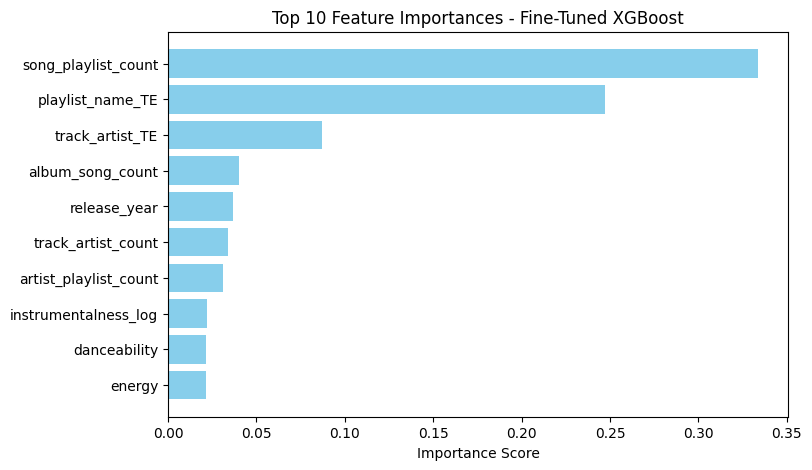

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(imp["feature"], imp["importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances - Fine-Tuned XGBoost")
plt.xlabel("Importance Score")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import os
save_dir = "/content/drive/MyDrive/Spotify_Project/6_Modeling"
os.makedirs(save_dir, exist_ok=True)

best_model.save_model(f"{save_dir}/xgb_finetuned_model2.json")
print("Fine-tuned XGBoost saved to:", f"{save_dir}/xgb_finetuned_model2.json")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fine-tuned XGBoost saved to: /content/drive/MyDrive/Spotify_Project/6_Modeling/xgb_finetuned_model2.json
